In [1]:
from math import ceil
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA
from geopandas import GeoDataFrame

In [2]:
file = 'MetroRail.geojson'
gdf = gpd.read_file(file)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NPTREF    190 non-null    object  
 1   RSTNAM    190 non-null    object  
 2   geometry  190 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 4.6+ KB


In [3]:
df = pd.read_csv('railandmetro_merged2.csv',
                 na_values=[':'], low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NPTREF         177 non-null    object 
 1   name           177 non-null    object 
 2   near_station   177 non-null    int64  
 3   freq           177 non-null    float64
 4   line           177 non-null    int64  
 5   bus_route      177 non-null    int64  
 6   car_park       177 non-null    int64  
 7   near_highway   177 non-null    float64
 8   sum_pop        177 non-null    int64  
 9   sum_lab        177 non-null    int64  
 10  poi_count      177 non-null    int64  
 11  entropy        177 non-null    float64
 12  access_lane    177 non-null    float64
 13  bike_capacity  177 non-null    int64  
 14  intersection   177 non-null    int64  
 15  pedstrain      177 non-null    float64
 16  ave_gmal       177 non-null    float64
 17  dc             177 non-null    float64
 18  cc        

In [4]:
ppd = pd.merge(df, gdf, left_on='NPTREF', right_on='NPTREF', how='inner').reset_index()
ppd.shape
ppd.head(5)

,index,NPTREF,name,near_station,freq,line,bus_route,car_park,near_highway,sum_pop,...,pedstrain,ave_gmal,dc,cc,bc,prp,greenspace,reach_target,RSTNAM,geometry
0,0,9100ARDWICK,ARDWICK,147,1.875,2,25,0,0.038448,1648,...,0.427932,17.415557,6.0,0.000219,6339.0,0.004625,39.259956,T,ARDWICK,POINT (-2.21337 53.47121)
1,1,9100ASHBRYS,ASHBURYS,148,105.000,3,27,0,0.057072,3239,...,0.691228,14.908093,9.0,0.000202,6191.0,0.007078,17.338474,T,ASHBURYS,POINT (-2.19475 53.47187)
2,2,9100ATHERTN,ATHERTON,55,60.000,2,21,70,0.024852,5808,...,0.609823,5.954318,7.0,0.000150,2799.0,0.005379,5.131645,F,ATHERTON,POINT (-2.47799 53.52911)
3,3,9100BAGE,BURNAGE,138,60.000,2,25,0,0.020860,10367,...,0.710716,10.157785,5.0,0.000191,2118.5,0.005094,29.306086,T,BURNAGE,POINT (-2.21523 53.42196)
4,4,9100BLLVUE,BELLE VUE,145,30.000,2,41,0,0.042632,7649,...,0.806737,13.282646,5.0,0.000184,2196.0,0.005125,36.697076,T,BELLE VUE,POINT (-2.18019 53.46179)


In [6]:
ppd = GeoDataFrame(ppd)

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

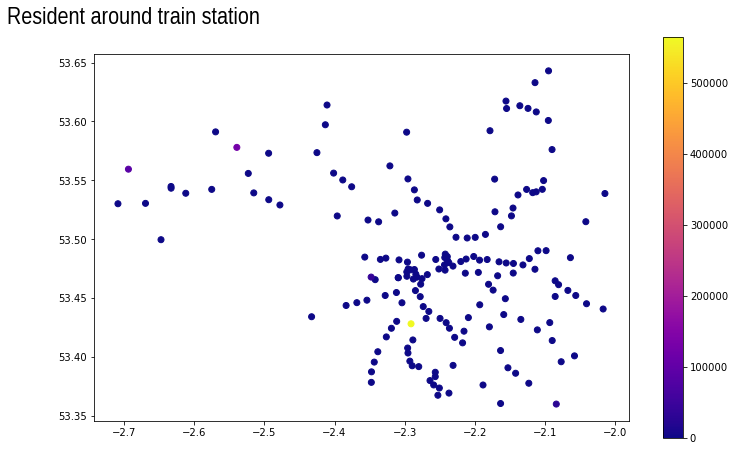

In [6]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='greenspace', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Resident around train station", x=0.025, size=24, **tfont);

In [5]:
to_cluster = ppd[['NPTREF','near_station','freq','line','bus_route','bike_capacity','car_park','near_highway','sum_pop','sum_lab','entropy','poi_count',
                 'access_lane','intersection','pedstrain','cc','bc','greenspace']].set_index('NPTREF').copy()
to_cluster.head()

,near_station,freq,line,bus_route,bike_capacity,car_park,near_highway,sum_pop,sum_lab,entropy,poi_count,access_lane,intersection,pedstrain,cc,bc,greenspace
NPTREF,,,,,,,,,,,,,,,,,
9100ARDWICK,147,1.875,2,25,0,0,0.038448,1648,472,2.157234,21,3.462621,6,0.427932,0.000219,6339.0,39.259956
9100ASHBRYS,148,105.000,3,27,0,0,0.057072,3239,980,-1.748754,13,2.330456,32,0.691228,0.000202,6191.0,17.338474
9100ATHERTN,55,60.000,2,21,7,70,0.024852,5808,2643,1.150809,7,1.943329,1,0.609823,0.000150,2799.0,5.131645
9100BAGE,138,60.000,2,25,40,0,0.020860,10367,4408,0.465909,33,0.856821,31,0.710716,0.000191,2118.5,29.306086
9100BLLVUE,145,30.000,2,41,0,0,0.042632,7649,2577,1.080704,13,0.741213,27,0.806737,0.000184,2196.0,36.697076


In [8]:
network_data = ppd[['NPTREF','dc','cc','bc','greenspace']].set_index('NPTREF').copy()
network_data.head()

,dc,cc,bc,greenspace
NPTREF,,,,
9100ARDWICK,6.0,0.000219,6339.0,39.259956
9100ASHBRYS,9.0,0.000202,6191.0,17.338474
9100ATHERTN,7.0,0.000150,2799.0,5.131645
9100BAGE,5.0,0.000191,2118.5,29.306086
9100BLLVUE,5.0,0.000184,2196.0,36.697076


In [6]:
to_cluster.describe()

,near_station,freq,line,bus_route,bike_capacity,car_park,near_highway,sum_pop,sum_lab,entropy,poi_count,access_lane,intersection,pedstrain,cc,bc,greenspace
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,109.570621,43.359463,2.169492,30.468927,97.237288,42.259887,0.023463,5707.118644,2603.711864,1.219487,77.875706,3.597380,33.282486,0.651624,0.000158,2204.841808,4860.672098
std,38.833954,52.791207,0.956186,17.451895,313.922164,112.028153,0.015797,3298.246291,1608.507157,2.306460,178.525228,2.365756,53.787771,0.119488,0.000039,2591.487802,44028.181101
min,13.000000,1.875000,1.000000,1.000000,0.000000,0.000000,0.001885,0.000000,0.000000,-6.495189,1.000000,0.000000,0.000000,0.149411,0.000090,0.000000,0.000000
25%,94.000000,10.000000,2.000000,21.000000,0.000000,0.000000,0.012501,3364.000000,1340.000000,0.677120,10.000000,1.811969,4.000000,0.591350,0.000127,623.000000,15.276332
50%,122.000000,25.000000,2.000000,28.000000,16.000000,0.000000,0.019238,5754.000000,2536.000000,1.089299,20.000000,3.150600,13.000000,0.668898,0.000155,1542.500000,28.068172
75%,139.000000,60.000000,2.000000,36.000000,50.000000,32.000000,0.030678,7483.000000,3480.000000,1.274947,50.000000,5.111205,38.000000,0.731423,0.000184,2758.000000,59.772271
max,152.000000,310.000000,9.000000,110.000000,2644.000000,1000.000000,0.084481,17688.000000,8561.000000,22.401314,1107.000000,9.914807,334.000000,0.876976,0.000260,19455.500000,564458.810100


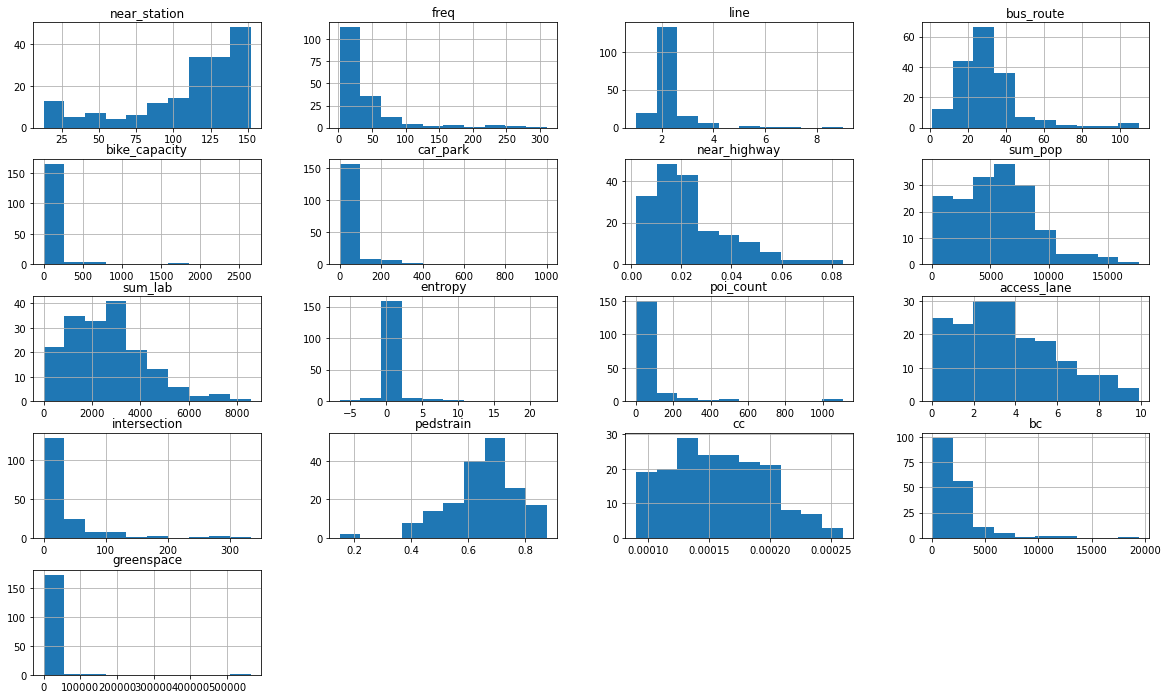

In [8]:
df_analyse_histograms = to_cluster.hist(figsize = (20,12))

In [7]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

,near_station,freq,line,bus_route,bike_capacity,car_park,near_highway,sum_pop,sum_lab,entropy,poi_count,access_lane,intersection,pedstrain,cc,bc,greenspace
NPTREF,,,,,,,,,,,,,,,,,
9400ZZMAQRD,1.171500,-0.208070,-0.004382,0.026183,-1.163892,-0.809067,1.110023,-0.365158,-0.778607,-0.009789,-0.387219,0.656251,-0.283825,-0.015293,1.199162,0.803937,0.777220
9100HMPHRYP,0.344247,-0.089702,-0.004382,-0.728825,-1.163892,-0.809067,-0.804888,1.142467,1.162112,-0.318957,0.148501,-1.154264,0.068375,0.186659,0.663945,0.002995,-0.221306
9100HITW,-1.819205,0.195555,-0.004382,0.026183,-1.163892,-0.809067,1.775891,-0.445152,-0.608271,-0.007460,-0.451684,-0.463630,0.194610,0.448947,-1.052973,-0.803590,0.429982
9400ZZMAWTD,0.722415,-0.208070,-0.004382,0.717986,1.122322,-0.809067,0.273880,1.519733,2.207587,-0.516726,0.148501,0.807725,-0.283825,0.031525,0.545586,-0.023521,-0.820196
9400ZZMACLN,1.299996,-0.918042,-0.004382,0.215769,0.709766,-0.809067,1.428285,0.365868,-0.207181,0.045159,-0.600150,0.687876,0.068375,0.678265,0.301384,0.289049,-0.141934


In [8]:
normnetwork = normed.copy()
for c in normed.columns.values:
    normnetwork[c] = mms.fit_transform(normed[c].values.reshape(-1,1))
normnetwork.sample(5)

,near_station,freq,line,bus_route,bike_capacity,car_park,near_highway,sum_pop,sum_lab,entropy,poi_count,access_lane,intersection,pedstrain,cc,bc,greenspace
NPTREF,,,,,,,,,,,,,,,,,
9400ZZMAHEA,0.708406,0.488646,0.391827,0.509850,0.552092,0.670212,0.405372,0.531494,0.541304,0.418533,0.535986,0.492961,0.115549,0.477829,0.485635,0.439970,0.742822
9100WSTHOTN,0.030316,0.731906,0.391827,0.402834,0.000000,0.848368,0.481235,0.598664,0.646734,0.279483,0.347605,0.404263,0.300692,0.594106,0.119180,0.174160,0.535910
9400ZZMARRS,0.099226,0.871640,0.726578,0.656797,0.641983,0.000000,0.415163,0.622092,0.455583,0.443622,0.586309,0.493709,0.576413,0.673544,0.103714,0.472441,0.543556
9400ZZMABAG,0.571189,0.341435,0.391827,0.602238,0.579571,0.000000,0.480227,0.389846,0.365463,0.440868,0.171749,0.489820,0.617365,0.367751,0.309001,0.521744,0.610773
9100DAISYH,0.050514,0.709437,0.391827,0.374055,0.000000,0.883248,0.589307,0.445187,0.461942,0.418721,0.347605,0.004700,0.349582,0.531283,0.336432,0.457788,0.587434


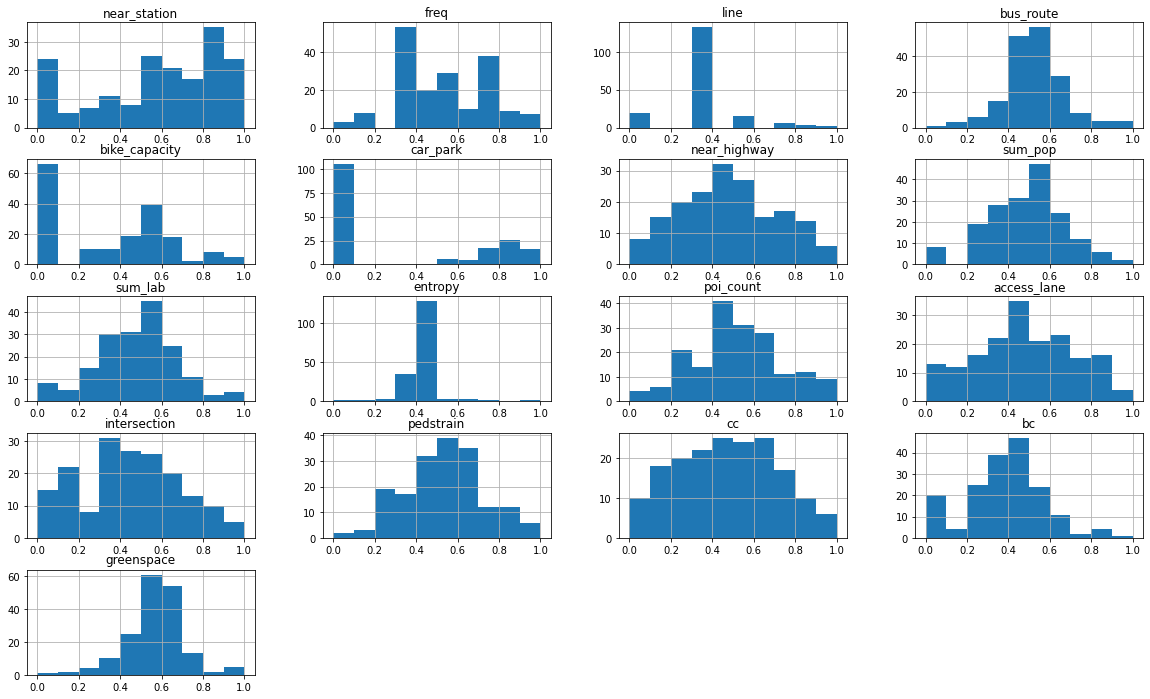

In [11]:
df_analyse_histograms = normnetwork.hist(figsize = (20,12))

NameError: name 'normed' is not defined

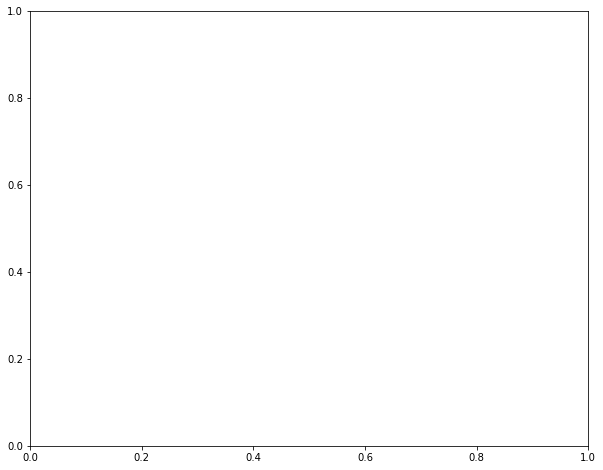

In [58]:
fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches

# plotting correlation heatmap
dataplot = sns.heatmap(np.round(normed.corr(),2), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

In [13]:
#normed.to_csv(r'normedmetrolink.csv', index = True)
normnetwork.to_csv(r'normmms.csv', index = True)

In [5]:
score_pca = pd.read_csv('tocluster1.csv',
                 na_values=[':'], low_memory=False)
score_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NPTREF  177 non-null    object 
 1   node    177 non-null    float64
 2   place   177 non-null    float64
 3   design  177 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.7+ KB


In [6]:
score_pca = score_pca[['NPTREF','node','place','design']].set_index('NPTREF').copy()
score_pca.head()

,node,place,design
NPTREF,,,
9100ARDWICK,0.367145,0.349991,0.347598
9100ASHBRYS,0.538912,0.342627,0.519418
9100ATHERTN,0.491276,0.441868,0.297449
9100BAGE,0.495650,0.597550,0.459946
9100BLLVUE,0.471573,0.489779,0.514099


In [7]:
for c in score_pca.columns.values:
    score_pca[c] = mms.fit_transform(score_pca[c].values.reshape(-1,1))
score_pca.sample(5)

,node,place,design
NPTREF,,,
9100SLFDCT,0.376979,0.455148,0.744719
9100ROHL,0.220036,0.463774,0.310343
9400ZZMAECC,0.531778,0.315110,0.720587
9400ZZMAWYT,0.287100,0.570739,0.722170
9400ZZMALWY,0.217354,0.600580,0.769983


In [8]:
score_pca.describe()

,node,place,design
count,177.000000,177.000000,177.000000
mean,0.369085,0.511140,0.521087
std,0.157807,0.198009,0.220152
min,0.000000,0.000000,0.000000
25%,0.260351,0.388649,0.340191
50%,0.366266,0.510185,0.524478
75%,0.467343,0.643339,0.715487
max,1.000000,1.000000,1.000000


In [11]:
score_pca1 = score_pca[['node','place','design']].copy()
score_pca1.head()

,node,place,design
NPTREF,,,
9100ARDWICK,0.237573,0.310216,0.340191
9100ASHBRYS,0.493830,0.298197,0.563939
9100ATHERTN,0.422761,0.460159,0.274885
9100BAGE,0.429288,0.714231,0.486494
9100BLLVUE,0.393367,0.538349,0.557011


/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


[0.31326763477766656]
[0.31326763477766656, 0.2773492428007443]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697]


/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945, 0.2742665192145921]


/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945, 0.2742665192145921, 0.264521931133263]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945, 0.2742665192145921, 0.264521931133263, 0.26525294452044496]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945, 0.2742665192145921, 0.264521931133263, 0.26525294452044496, 0.27452616699855675]


/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945, 0.2742665192145921, 0.264521931133263, 0.26525294452044496, 0.27452616699855675, 0.2722054359181127]
[0.31326763477766656, 0.2773492428007443, 0.2885948725727709, 0.28352240622937697, 0.2577337558086179, 0.2686443318282814, 0.26441312215236945, 0.2742665192145921, 0.264521931133263, 0.26525294452044496, 0.27452616699855675, 0.2722054359181127, 0.2663969592605031]


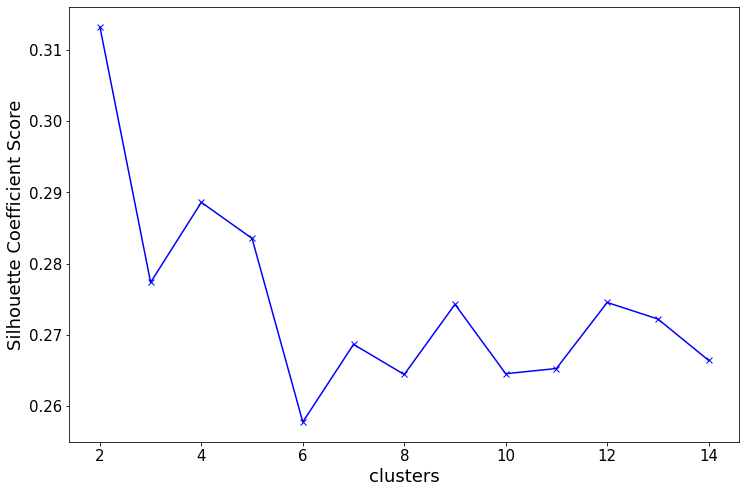

In [14]:
#分别创建分群2-15的KMeans模型
clusters = range(2,15)
sc_scores = []
for k in clusters:  
    kmeans_model = KMeans(n_clusters=k, n_jobs = 6).fit(score_pca1)
    sc_score = metrics.silhouette_score(score_pca1, kmeans_model.labels_\
                        ,sample_size=10000, metric='euclidean')
    sc_scores.append(sc_score)
    print(sc_scores)
#作出K—平均轮廓系数曲线
plt.figure()
plt.plot(clusters, sc_scores, 'bx-')
plt.rcParams['figure.figsize'] = [12,8]
plt.xlabel('clusters',fontsize=18)
plt.ylabel('Silhouette Coefficient Score',fontsize=18)  #样本平均轮廓系数
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

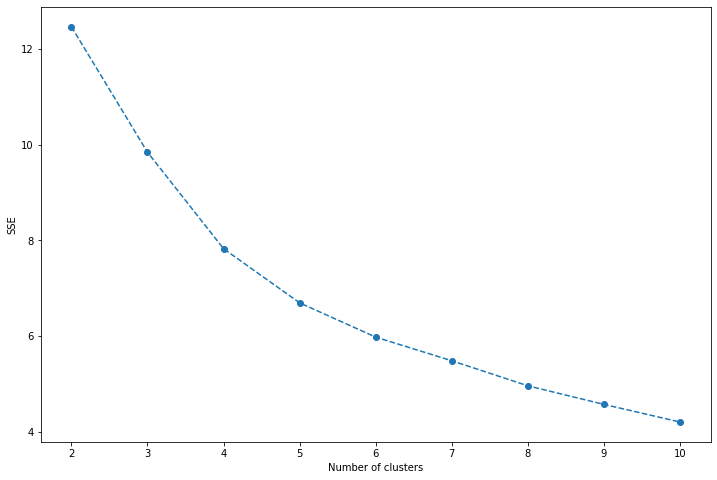

In [13]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 2
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca1)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [15]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca1)

KMeans(n_clusters=2, random_state=1)

In [16]:
score_pca1['Kmeans_Cluster'] = kmeans_method.labels_
score_pca1['Segement'] = score_pca1['Kmeans_Cluster'].map({0:'Cluster1',1:'Cluster2',2:'Cluster3',3:'Cluster4',4:'Cluster5',5:'Cluster6',6:'Cluster7',7:'eighth'})

In [17]:
score_pca_merge = pd.merge(score_pca1, gdf, left_on='NPTREF', right_on='NPTREF', how='inner').reset_index()
score_pca_merge.shape
score_pca_merge.head(5)

,index,NPTREF,node,place,design,Kmeans_Cluster,Segement,RSTNAM,geometry
0,0,9100ARDWICK,0.237573,0.310216,0.340191,0,Cluster1,ARDWICK,POINT (-2.21337 53.47121)
1,1,9100ASHBRYS,0.493830,0.298197,0.563939,0,Cluster1,ASHBURYS,POINT (-2.19475 53.47187)
2,2,9100ATHERTN,0.422761,0.460159,0.274885,0,Cluster1,ATHERTON,POINT (-2.47799 53.52911)
3,3,9100BAGE,0.429288,0.714231,0.486494,1,Cluster2,BURNAGE,POINT (-2.21523 53.42196)
4,4,9100BLLVUE,0.393367,0.538349,0.557011,1,Cluster2,BELLE VUE,POINT (-2.18019 53.46179)


In [18]:
score_pca_merge = GeoDataFrame(score_pca_merge)

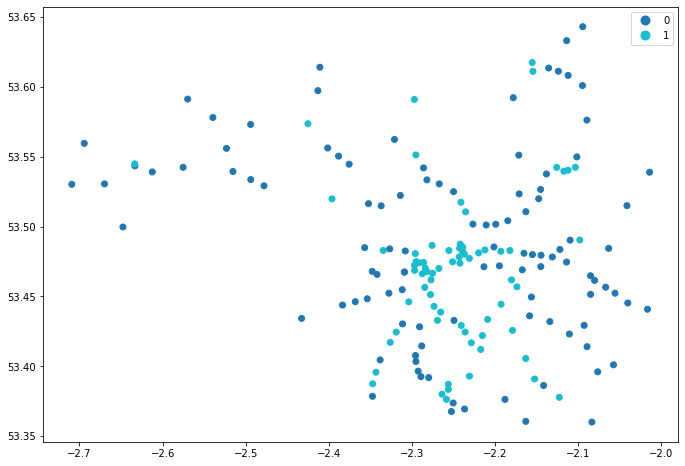

In [19]:
score_pca_merge.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


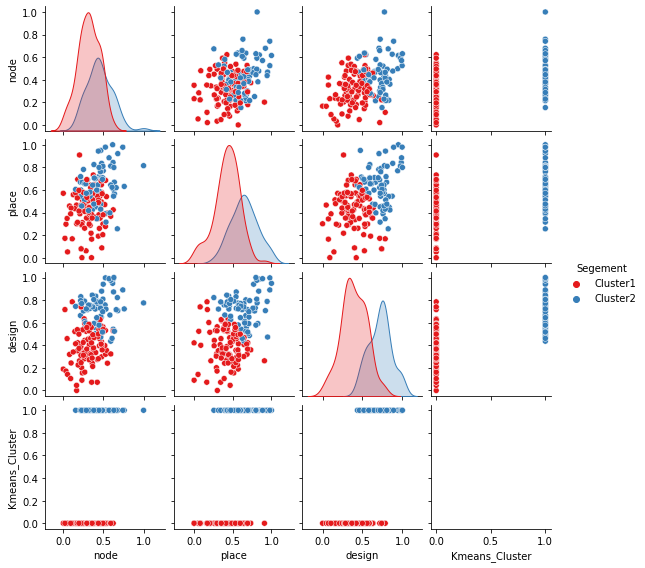

In [20]:
plot_norm = sns.pairplot(score_pca1,hue = 'Segement',height = 2,palette = 'Set1')

In [52]:
score_pca_merge.to_csv(r'cwithoutpca.csv', index = False)